In [1]:
#Import libraries
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
#Initialize Spark Session (force local mode for stability)
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("RetailSalesAnalytics") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()
print("✅ Spark Session Initialized Successfully")

✅ Spark Session Initialized Successfully


In [2]:
#Load Dataset
data_path = "online_retail.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

print("Total Records:", df.count())
df.printSchema()

Total Records: 541909
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [3]:
#Data Cleaning (Fixed Timestamp Conversion)
df = df.dropna(subset=["CustomerID", "InvoiceNo", "StockCode", "Description"])
df = df.filter(col("Quantity") > 0)
df = df.filter(col("UnitPrice") > 0)
# Add total sales column
from pyspark.sql.functions import expr
# Add total sales column
df = df.withColumn("TotalSales", col("Quantity") * col("UnitPrice"))
df = df.withColumn(
    "InvoiceDate",
    expr("try_to_timestamp(InvoiceDate, 'MM/dd/yyyy H:mm')")
)
df = df.dropna(subset=["InvoiceDate"])
# Extract date components
df = df.withColumn("Year", year("InvoiceDate")) \
       .withColumn("Month", month("InvoiceDate")) \
       .withColumn("DayOfWeek", dayofweek("InvoiceDate"))
print("✅ Data Cleaning Completed (Date Parsing Fixed ✅)")

✅ Data Cleaning Completed (Date Parsing Fixed ✅)


In [4]:
#Exploratory Data Analysis (EDA)
monthly_sales = df.groupBy("Year", "Month").agg(sum("TotalSales").alias("MonthlySales")).orderBy("Year", "Month")
monthly_sales.show(5)

+----+-----+-----------------+
|Year|Month|     MonthlySales|
+----+-----+-----------------+
|2010|   12|260835.8900000026|
|2011|   10|730618.9800000034|
|2011|   11|805673.6400000025|
+----+-----+-----------------+



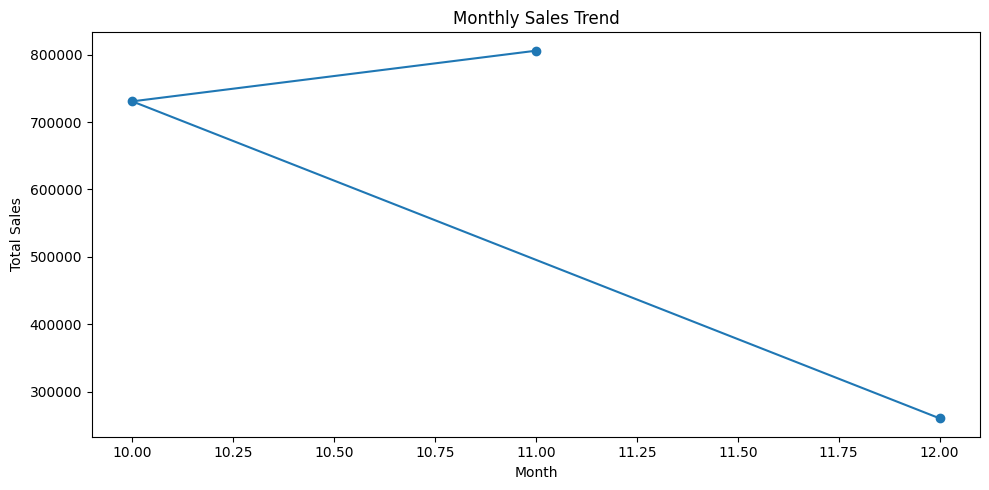

In [5]:
#Visualization - Monthly Sales Trend
os.makedirs("plots_retail", exist_ok=True)
pdf = monthly_sales.toPandas()
plt.figure(figsize=(10,5))
plt.plot(pdf["Month"], pdf["MonthlySales"], marker='o', color='tab:blue')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.savefig("plots_retail/monthly_sales_trend.png")
plt.show()

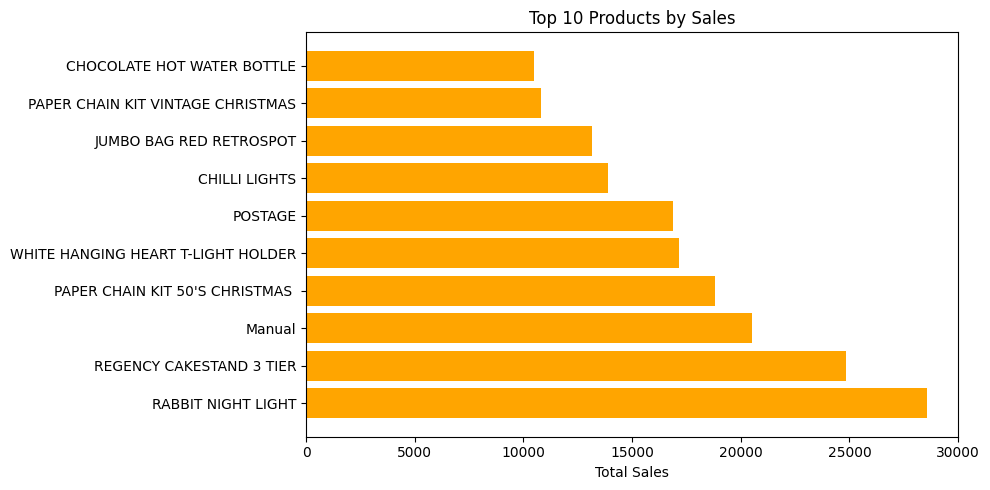

In [6]:
#Top 10 Products by Sales
top_products = df.groupBy("Description").agg(sum("TotalSales").alias("Sales")).orderBy(desc("Sales")).limit(10)
pdf = top_products.toPandas()
plt.figure(figsize=(10,5))
plt.barh(pdf["Description"], pdf["Sales"], color="orange")
plt.title("Top 10 Products by Sales")
plt.xlabel("Total Sales")
plt.tight_layout()
plt.savefig("plots_retail/top_10_products.png")
plt.show()

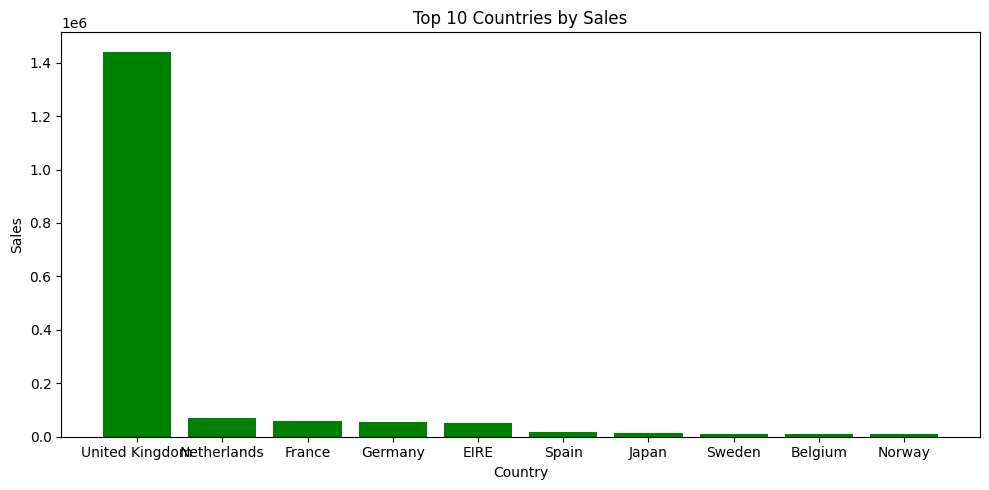

Visualizations Generated Successfully


In [7]:
#Top 10 Countries by Sales
country_sales = df.groupBy("Country").agg(sum("TotalSales").alias("Sales")).orderBy(desc("Sales"))
pdf = country_sales.toPandas().head(10)
plt.figure(figsize=(10,5))
plt.bar(pdf["Country"], pdf["Sales"], color="green")
plt.title("Top 10 Countries by Sales")
plt.xlabel("Country")
plt.ylabel("Sales")
plt.tight_layout()
plt.savefig("plots_retail/top_10_countries.png")
plt.show()
print("Visualizations Generated Successfully")

In [8]:
#Feature Engineering for ML
invoice_df = df.groupBy("InvoiceNo", "Year", "Month", "DayOfWeek").agg(
    sum("Quantity").alias("TotalQty"),
    sum("UnitPrice").alias("TotalUnitPrice"),
    sum("TotalSales").alias("InvoiceSales")
)
assembler = VectorAssembler(
    inputCols=["TotalQty", "TotalUnitPrice", "Month", "DayOfWeek"],
    outputCol="features"
)
data_ml = assembler.transform(invoice_df).select("features", col("InvoiceSales").alias("label"))
print("Feature Engineering Completed")

Feature Engineering Completed


In [9]:
#Train-Test Split and Model Training
train_data, test_data = data_ml.randomSplit([0.7, 0.3], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)
print("Model Training Completed")

Model Training Completed


In [10]:
#Model Evaluation
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions)
print(f"Model Evaluation Results:\nRMSE = {rmse:.2f}\nR2 Score = {r2:.3f}")

Model Evaluation Results:
RMSE = 276.52
R2 Score = 0.806


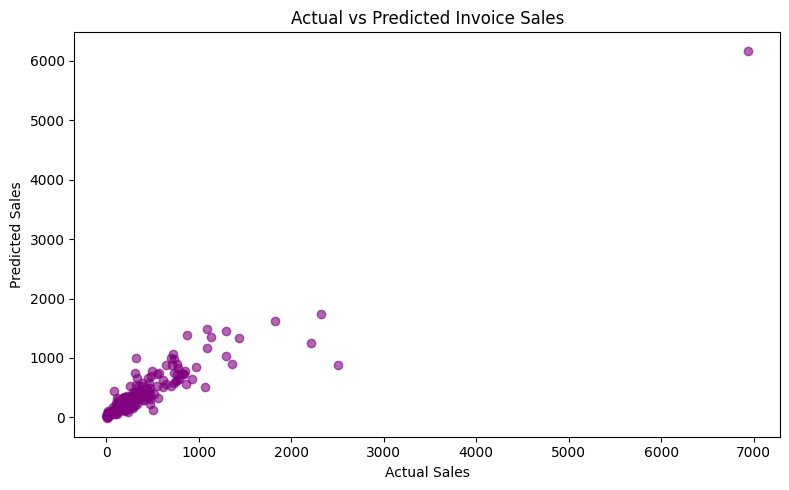

In [11]:
#Actual vs Predicted Visualization
pdf = predictions.select("label", "prediction").toPandas().sample(200)
plt.figure(figsize=(8,5))
plt.scatter(pdf["label"], pdf["prediction"], alpha=0.6, color="purple")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Invoice Sales")
plt.tight_layout()
plt.savefig("plots_retail/actual_vs_predicted.png")
plt.show()

In [13]:
# Convert Spark DataFrame to Pandas
df_pd = df.toPandas()
df_pd.to_csv("cleaned_retail_data.csv", index=False)
print("Cleaned data saved to 'cleaned_retail_data.csv'")



Cleaned data saved to 'cleaned_retail_data.csv'


In [14]:
#Stop Spark Session
spark.stop()
print("Spark Session Stopped. Project Completed Successfully.")


Spark Session Stopped. Project Completed Successfully.
